<a href="https://colab.research.google.com/github/falseywinchnet/PyITD/blob/main/tiny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#copyright joshuah.rainstar@gmail.com 2025 TG skymasterskymaster
#some code borrowed from karapathy's nanogpt, pytorch.
#nanogpt copyright karapathy, code used = insubstantial
#Christ is King

from __future__ import annotations
import math
import typing
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from matplotlib import pyplot as plt

import torch
import torch.nn as nn



class ZLS(nn.Module):
    """
    Zero-crossing Logistic-subtracted Softplus activation
    """
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        sp = F.softplus(x)                    # numerically stable softplus
        sa = torch.sigmoid(0.5 * x)             # s_a(x) with learned optimal shape param
        ba = sa * (1.0 - sa)                  # s_a(x) * (1 - s_a(x))
        return sp - 2.77258872223978123766 * ba #4-log(2) yields zero crossing behavior



def _cnorm(z: torch.Tensor, dim: int = -1, eps: float = 1e-8) -> torch.Tensor:
    denom = torch.linalg.vector_norm(z, ord=2, dim=dim, keepdim=True).clamp_min(eps)
    return z / denom
def append_distance_from_last(x: torch.Tensor, eps: float = 1e-8, mode: str = "cosine") -> torch.Tensor:
    """
    x: [B, T, C]  (real or complex)
    returns: [B, T, C+1]
      - last channel is distance-from-last-token (t = T-1) per token t

    mode:
      "cosine"        -> clamped cosine similarity in [-1+eps, 1-eps]
      "one_minus_cos" -> 1 - clamped cosine (∈ [0+eps, 2-eps])
      "angle"         -> angular distance arccos(clamped cosine) / pi  (∈ [0,1])
    """
    B, T, C = x.shape
    if T == 0:
        return torch.cat([x, torch.empty(B, T, 1, device=x.device, dtype=x.dtype)], dim=-1)

    # normalize on the hypersphere
    v = _cnorm(x, dim=-1, eps=eps)                       # [B, T, C]

    # anchor: last token vector (broadcast across T)
    a = v[:, -1:, :]                                     # [B, 1, C]
    a = a.expand(B, T, C)                                # [B, T, C]

    # complex-safe cosine
    cos = (v * a.conj()).sum(dim=-1)                     # [B, T]
    if cos.is_complex():
        cos = cos.real

    # clamp for numerical stability
    cos = cos.clamp(-1.0 + eps, 1.0 - eps)

    # choose distance scalar
    if mode == "cosine":
        dist = cos
    elif mode == "one_minus_cos":
        dist = 1.0 - cos
    elif mode == "angle":
        dist = torch.arccos(cos) / torch.pi
    else:
        raise ValueError(f"Unknown mode: {mode}")

    # append as last channel
    dist = dist.unsqueeze(-1)                             # [B, T, 1]
    return torch.cat([x, dist], dim=-1)                   # [B, T, C+1]

class Cell(nn.Module):
    def __init__(self, dim_in: int, hidden: int):
        super().__init__()
        self.fc1 = nn.Linear(dim_in, hidden, bias=False) #dont change, false intentional
        torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='selu') #dont change, selu intentional
        self.fc2 = nn.Linear(hidden, dim_in, bias=True)
        torch.nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='selu') #dont change, selu intentional
        self.act = ZLS()
    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

class CellDecode(nn.Module):
    def __init__(self, dim_in: int, hidden: int,dim_out:int):
        super().__init__()
        self.fc1 = nn.Linear(dim_in, hidden, bias=False) #dont change, false intentional
        torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='selu') #dont change, selu intentional
        self.fc2 = nn.Linear(hidden, dim_out, bias=True)
        torch.nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='selu') #dont change, selu intentional
        self.act = ZLS()
    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

class RecurrentMLP(nn.Module):
    def __init__(self, dim_in: int):
        super().__init__()
        self.k = 2 #can set to 3, but marginal gains
        self.hidden = dim_in*2 #if overfitting reduce to dim_in or even dim_in//2
        self.cells_a = nn.ModuleList([Cell(dim_in, self.hidden) for _ in range(self.k)])
    def forward(self, x):
        z = x
        for i in range(self.k):
            z = z + self.cells_a[i](z)
        return z


class InformedMLP2D(nn.Module):
    def __init__(self, block_size: int, dim_in:int):
        super().__init__()
        h = block_size
        w = dim_in + 1    # +1 because append_distance_from_last increases channels
        self.head = RecurrentMLP(w)
        self.decoder = CellDecode(w,w*2,dim_in)
    def forward(self, x):
        B,_,_ = x.shape
        x = append_distance_from_last(x) # [B, T, C+1]
        out= torch.sum(x,dim=1)
        return self.decoder(self.head(out))                              # (B,1,C)


class runOverlapping(nn.Module):
    def __init__(self, dim_in: int):
        super().__init__()
        # block_size = dim_in, channels = dim_in
        self.mlp = InformedMLP2D(dim_in, dim_in)
        self.decode = RecurrentMLP(dim_in)

    def _slide_once(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, T, C] with C == dim_in
        B, T, C = x.shape
        W = T - C
        if W <= 0:
            raise ValueError("Require T > C to produce T - C overlapping windows.")

        # windows: [B, T - C + 1, C, C] then cut to W = T - C
        windows = x.unfold(dimension=1, size=C, step=1)[:, :W]  # [B, W, C, C]

        # batch all windows
        B0, W0, H, C0 = windows.shape
        assert H == C and C0 == C, "Unexpected window shape."
        windows = windows.contiguous().view(B0 * W0, C, C)      # [B*W, C, C]

        # InformedMLP2D expects [B*, h=C, w=C] -> append_distance -> [B*, C, C+1]
        # head maps (h,w)=(C,C+1) to (1,C), so output is [B*W, 1, C]
        y = self.mlp(windows)                                   # [B*W, 1, C]

        # restore [B, W, C]
        out = y.squeeze(1).view(B0, W0, C)                      # [B, W, C]
        return out

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out_fwd = self._slide_once(x)                           # [B, T - C, C]
        return self.decode(out_fwd)                             # [B, T - C, C]

class Mixer(nn.Module):
    def __init__(self, config, eps=1e-16, dw_kernel=7):
        super().__init__()
        self.emb = config.n_embd
        self.eps = eps
        self.dwk = dw_kernel
        self.dw = nn.Conv1d(
            in_channels=self.emb, out_channels=self.emb, kernel_size=3, groups=self.emb, bias=False
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B,T,C], real
        # causal depthwise conv over time
        k = self.dw.kernel_size[0]
        Zt = x.transpose(1, 2)                                         # [B,C,T]
        Zc = self.dw(F.pad(Zt, (k - 1, 0)))                            # [B,C,T]
        return Zc.transpose(1, 2).to(x.dtype)                          # [B,T,C]

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, None, 1e-5)


class BlockFast(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.moe  = runOverlapping(config.n_embd)
        self.n_embd = config.n_embd
        self.attn = Mixer(config)
    def forward(self, x):
        x_attn  = self.attn(x)
        x_attn = self.moe(x_attn)
        q = x.clone()
        q[:,config.n_embd:,:] += x_attn
        return q

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
from torch.utils.checkpoint import checkpoint
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        self.n_embd = config.n_embd

        self.transformer = nn.ModuleDict(dict(
            wte =  nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([BlockFast(config) for _ in range(config.n_layer)]),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        #

        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))
    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())

        return n_params


    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        embeddings = self.transformer.wte(idx)
        embeddings = embeddings
        x = self.transformer.drop(embeddings)
        # Get shared constants for this sequence length
        for block in self.transformer.h:
            x = checkpoint(block, x, use_reentrant=False) # recompute activations on backward

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss


In [ ]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [ ]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,#"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [ ]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 2048
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )


config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=12,
    n_embd=16,
    dropout=0.1,
    block_size=block_size
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

model = GPT(config)


model = model.to(device)



number of parameters: 0.07M


In [ ]:
#print model params
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 69456


In [ ]:
def make_taper_weights(block_size, warmup_len):
    """
    Create a vector of length block_size with values tapering from ~0 to 1.
    warmup_len = config.n_layer * config.n_embd
    """
    # linearly spaced from 1e-16 -> 1.0
    taper = torch.linspace(1e-16, 1.0, steps=block_size)
    # clamp: the first warmup_len positions are in the taper, rest are 1.0
    taper[:warmup_len] = torch.linspace(1e-16, 1.0, steps=warmup_len)
    taper[warmup_len:] = 1.0
    return taper

losses = []
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
taper_weights = make_taper_weights(block_size, config.n_layer * config.n_embd).to(device)

def train_epoch():
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb[0], yb[0]  # unwrap
        optimizer.zero_grad()

        logits, _ = model(xb, yb)  # shape [B, T, vocab]
        B, T, V = logits.shape

        logits_flat = logits.view(-1, V)
        targets_flat = yb.view(-1)

        # expand taper across batch
        weights = taper_weights.repeat(B)

        loss = F.cross_entropy(
            logits_flat,
            targets_flat,
            reduction="none"
        )
        loss = (loss * weights).sum() / weights.sum()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        losses.append(loss.item())
        print(loss.item())

    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

2.1292715072631836
2.2475290298461914
2.12485933303833
2.1882174015045166
2.1412901878356934
2.1767702102661133
2.138228416442871
2.1240150928497314
2.077615976333618
2.1342382431030273
2.1434755325317383
2.1391286849975586
2.1235930919647217
2.102980613708496
2.0817699432373047
2.1417412757873535
2.09869384765625
2.113685369491577
2.0683112144470215
2.0336945056915283
2.093594551086426
2.139328956604004
2.125253677368164
2.118683338165283
2.1126790046691895
2.1283810138702393
2.120338201522827
2.0715928077697754
2.124140977859497
2.1507692337036133
2.1733615398406982
2.099844217300415
2.107215404510498
2.1180169582366943
2.119401216506958
2.1157751083374023
2.116494655609131
2.1108834743499756
2.129525899887085
2.095139265060425
2.142627477645874
2.1135528087615967
2.139585018157959
2.1317877769470215
2.0892152786254883
2.076340436935425
2.129937171936035
2.1313793659210205
2.1617650985717773
2.107330322265625
2.0998473167419434
2.0808379650115967
2.0900590419769287
2.12919020652771
2

KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

@torch.no_grad()
def eval_bits_per_char(model, val_ids, block_size=1024, max_batches=200, device=None):
    """
    Computes BPC and PPL on random contiguous slices.
    Assumes ?1 the loss returned by model(x, y) is mean NLL per token.
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    total_nll_nat = 0.0
    total_tokens = 0

    for _ in range(max_batches):
        if len(val_ids) <= block_size + 1:
            break

        start = np.random.randint(0, len(val_ids) - block_size - 1)
        x = torch.tensor(val_ids[start:start+block_size], dtype=torch.long, device=device)[None, :]
        y = torch.tensor(val_ids[start+1:start+block_size+1], dtype=torch.long, device=device)[None, :]

        # IMPORTANT: pass y so the model returns a sequence loss
        logits, loss = model(x, y)

        # If model doesn’t return loss for some reason, compute it safely
        if loss is None:
            # Handle both possible logits shapes
            if logits.dim() == 3 and logits.size(1) == x.size(1):
                # full sequence logits [B, T, V]
                B, T, V = logits.shape
                ce = F.cross_entropy(logits.view(-1, V), y.view(-1), reduction="mean")
                nll_nat = ce.item()
                tokens = T * B
            elif logits.dim() == 2:
                # last-step logits [B, V] -> only evaluate the last target
                ce = F.cross_entropy(logits, y[:, -1], reduction="mean")
                nll_nat = ce.item()
                tokens = logits.size(0)  # B tokens (here 1)
            else:
                raise ValueError(f"Unexpected logits shape: {tuple(logits.shape)}")
        else:
            # ?1 assume this is mean NLL per token (standard)
            nll_nat = float(loss.item())
            tokens = x.numel()  # B * T

        total_nll_nat += nll_nat * tokens
        total_tokens  += tokens

    if total_tokens == 0:
        return float("nan"), float("nan")

    avg_nll_nat = total_nll_nat / total_tokens
    bpc = avg_nll_nat / np.log(2.0)
    ppl = float(np.exp(avg_nll_nat))
    return bpc, ppl

bpc, ppl = eval_bits_per_char(model, val_ids, block_size=2048, max_batches=200, device=device)
print("BPC:", bpc, "Perplexity:", ppl)


BPC: 3.0301282059137207 Perplexity: 8.168822900487433


In [ ]:
#num smaller= better
#Models with <100k parameters usually collapse to gibberish or never beat 5-gram.
#BPC of NGRAM is ~3.5-4

In [ ]:
import torch
import torch.nn.functional as F

def expected_rank_of_token(scores: torch.Tensor,
                           token_ids: torch.Tensor,
                           temperature: float = 1.0) -> torch.Tensor:
    """
    Computes the expected rank of the given token at each position, without full V x V matrix.
    """
    # scores: (..., V), token_ids: (...,)

    # Gather score of the target token
    score_i = scores.gather(-1, token_ids.unsqueeze(-1))  # (..., 1)

    # Δ_j = score_j - score_i
    diff = scores - score_i  # (..., V)

    # P(j beats i)
    p = torch.sigmoid(diff / temperature)

    # Expected rank = 1 + sum_j P(j > i)
    return 1.0 + p.sum(dim=-1)  # (...,)


def rank_future_sequence_loss_soft(
    logits: torch.Tensor,
    targets: torch.Tensor,
    max_future_steps: int = 15,
    decay: float = 0.5,
    temperature: float = 1.0,
    reduction: str = "mean",
):
    """
    Memory-efficient smooth rank loss. For each t, matches rank of x_{t+Δ} to Δ.
    logits  … (B, T, V) – model scores
    targets … (B, T)    – token ids
    """
    B, T, V = logits.shape
    device = logits.device
    total_loss = torch.tensor(0.0, device=device)

    for Δ in range(2, max_future_steps + 1):
        if Δ >= T:
            break

        # Current time-step logits (for rank eval)
        cur_logits  = logits[:, :-Δ, :]          # (B, T−Δ, V)
        fut_targets = targets[:, Δ:]             # (B, T−Δ)

        # Efficient rank of ground-truth future token
        tgt_exp_rank = expected_rank_of_token(cur_logits, fut_targets, temperature)  # (B, T−Δ)

        # Penalize distance from desired rank Δ
        step_loss = F.l1_loss(
            tgt_exp_rank,
            torch.full_like(tgt_exp_rank, float(Δ)),
            reduction=reduction
        )

        # Apply decay for further future steps
        total_loss = total_loss + step_loss * (decay ** (Δ - 1))

    return total_loss


def ordered_future_loss(logits: torch.Tensor,
                        targets: torch.Tensor,
                        N: int = 15,
                        decay: float = 0.7,
                        tau: float = 1.0,
                        reduction: str = "mean"):
    """
    Penalise when the logits at step t do *not* respect the order of the next N tokens.

        top-1 logit should match token t+1
        top-2 logit should match token t+2
        ...
        top-N logit should match token t+N

    logits  – (B, T, V)
    targets – (B, T)
    """
    B, T, V = logits.shape
    device  = logits.device

    if N < 2:
        return torch.tensor(0., device=device)

    # windows where t+N fits in sequence
    valid_T = T - (N + 1)
    if valid_T <= 0:
        return torch.tensor(0., device=device)

    # (B, valid_T, N) → future token ids for each offset 2..N
    future_ids = torch.stack([targets[:, 2+k : 2+k+valid_T] for k in range(N)],
                         dim=-1)

    # (B, valid_T, N) → gather logits of those future tokens *now* (at step t)
    step_logits = logits[:, :valid_T, :].gather(
        -1, future_ids)                       # logit(x_{t+k})

    # pair-wise differences  Δ_{k,j} = logit_k − logit_j, shape (B, valid_T, N, N)
    diff = step_logits.unsqueeze(-1) - step_logits.unsqueeze(-2)

    # upper-triangular mask k<j (ignore diag & lower triangle)
    k_lt_j = torch.triu(torch.ones(N, N, device=device, dtype=torch.bool), 1)

    # logistic ranking loss
    pair_loss = F.softplus(-diff / tau)       # log(1+e^{-Δ/τ})
    pair_loss = pair_loss[..., k_lt_j]        # keep k<j entries, now shape (B, valid_T, M)

    # geometric weights per k (distance from current step)
    k_idx = torch.arange(N, device=device)
    weight = decay ** k_idx                   # shape (N,)
    # broadcast to pair-wise (k<j) selector
    weight_pair = weight.unsqueeze(-1).expand(N, N)[k_lt_j]  # (M,)

    pair_loss = pair_loss * weight_pair       # (B, valid_T, M)

    if reduction == "mean":
        return pair_loss.mean()
    elif reduction == "sum":
        return pair_loss.sum()
    else:                                     # 'none'
        return pair_loss                      # (B, valid_T, M)


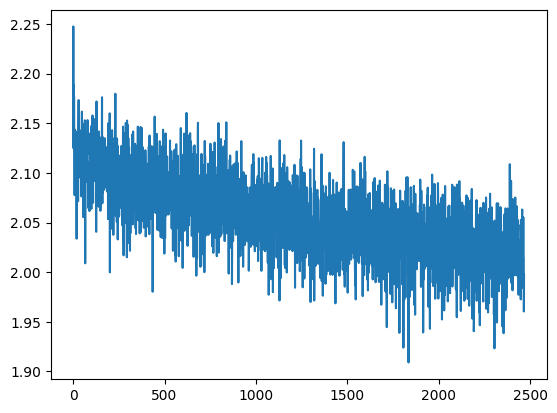

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [ ]:
@torch.no_grad()
def eval_ce_aligned(mmap_file, n_batches=200):
    model.eval()
    T = block_size
    pad_len = 0#int(getattr(model.config, "phase_pad_len", 0))
    losses = []
    N = len(mmap_file)
    # need pad_len + T + 1 tokens for X and Y when prefix comes from data
    lo = pad_len
    hi = N - T - 2
    for _ in range(n_batches):
        start = np.random.randint(lo, hi)
        x_all = np.array(mmap_file[start - pad_len:start + T], dtype=np.int64)      # [pad_len+T]
        y_vis = np.array(mmap_file[start + 1:start + 1 + T], dtype=np.int64)        # [T]
        X = torch.from_numpy(x_all).unsqueeze(0).to(device)
        Y = torch.from_numpy(y_vis).unsqueeze(0).to(device)
        _, loss = model(X, Y)
        losses.append(loss.item())
    return float(np.mean(losses))

print("val   CE:", eval_ce_aligned(val_ids,   n_batches=200))

val   CE: 2.089285095334053


In [ ]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO! ROMEO! ROMEO!"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=2048,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.8
)

print(generated)


ROMEO! ROMEO! ROMEO!

Third Herteesan.

Shechesd:
I psasth the prong; bo ty have and are,
What he censend lote this tiees you have ald thein stirs.

QUEEN MARGARET:
For muakly witl sence, out of these tine;
To the coreris, fare nith mis ans erute;
That thoug so fous net rede th your tore:
And thet eacharer and nof ham bulvent,
And ant you dast I se sramef and andous susest
efit is pouct bean de to the more condend,
The prome of the erea's dore sholl'd whather 'ed,
And y that theo oak, Engor and Lorter with,
A bead the enst thome foreithine hake my eameto.

RUMES:
By ningen sere the ponge, be the sendetel ne,
To shaly menne in him Wert thay mest cesthal stond
ho eres sore mefour wiod so tire hive feathind.

HESRUSHOLENE:
Nha fatr wo dane the eprerther on thy best
Hir lingre minnen, dors ass ling or asbe
And blouce th ofr the elael hepa te like his soro.

CORIOLANUS:
Gade home porisgle come, stanl that the maig, 
UO Momin ay fordeco, ne thae ir it mare.

QUEEN MARGARIT:
God. I wark, whti

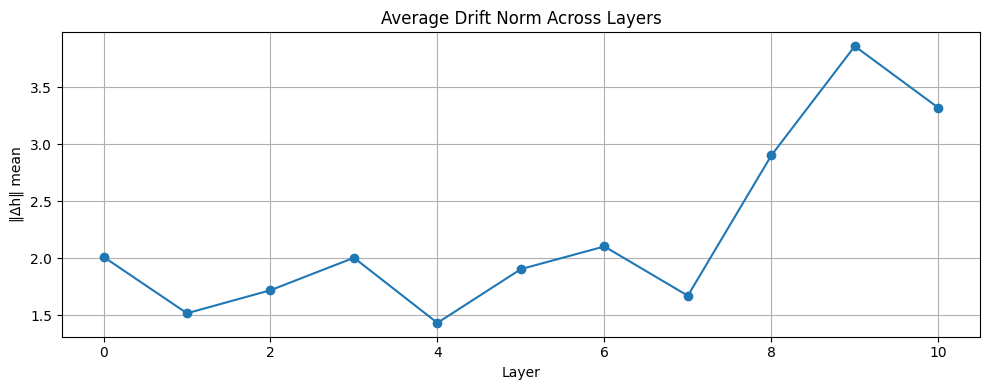

Jacobian rank (final token, projected): 16


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        embeddings = torch.cat([self.transformer.wte[i](idx)  for i in range(self.n_head)], dim=-1)
        embeddings = embeddings + pos_emb
        x = self.transformer.drop(embeddings)
        x_orig = x.clone()
        for stage in self.transformer.h:  # stages are ExplorerEngineerStage
          x = stage(x, x_orig)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss
'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # token + pos emb
    tok_emb = model.transformer.wte(tok)
    x = model.transformer.drop(tok_emb)  # [B, T_all, C]

    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    tok_emb = model.transformer.wte(tok)
    emb = tok_emb

    def forward_emb(emb_input):
        x = model.transformer.drop(emb_input)
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    tok_emb = model.transformer.wte(tok)
    x = model.transformer.drop(tok_emb)

    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, tok_emb.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


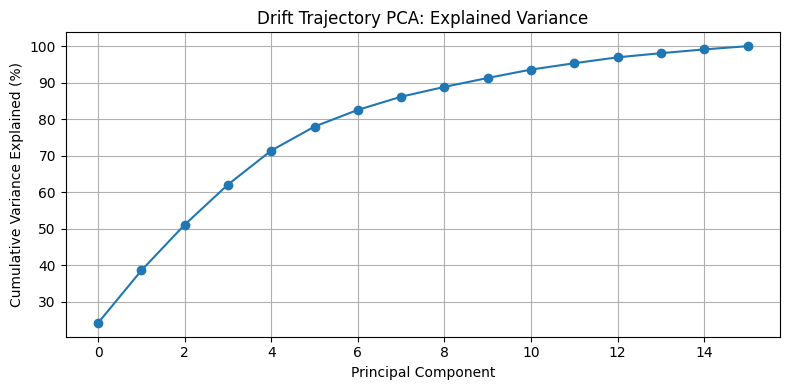

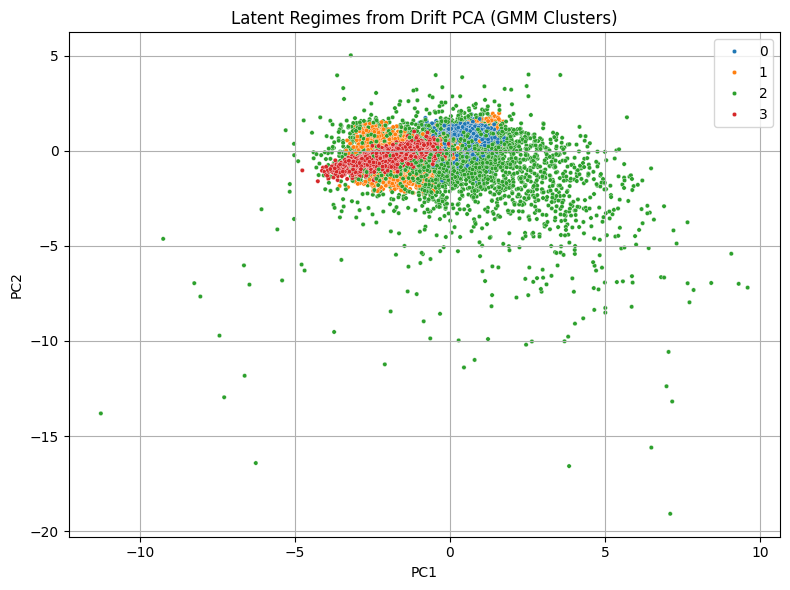

In [ ]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)



🔍 Probe: ['why', 'what', 'where', 'when'] vs who


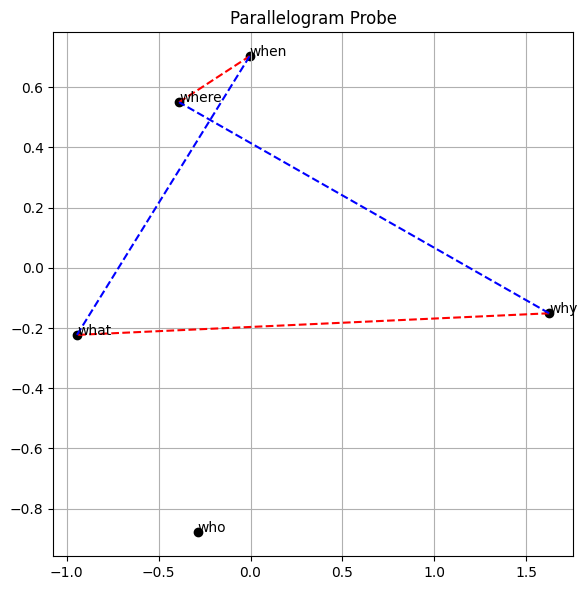


🔍 Probe: ['prepare', 'begin', 'cease', 'end'] vs remain


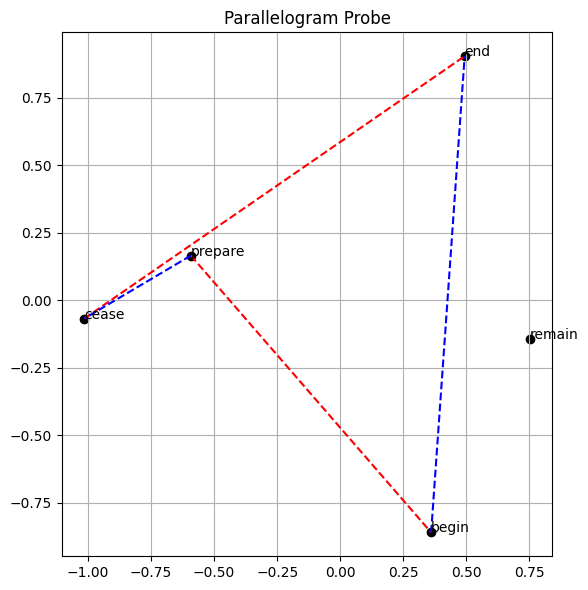


🔍 Probe: ['happy', 'sad', 'disagreeable', 'willing'] vs afraid


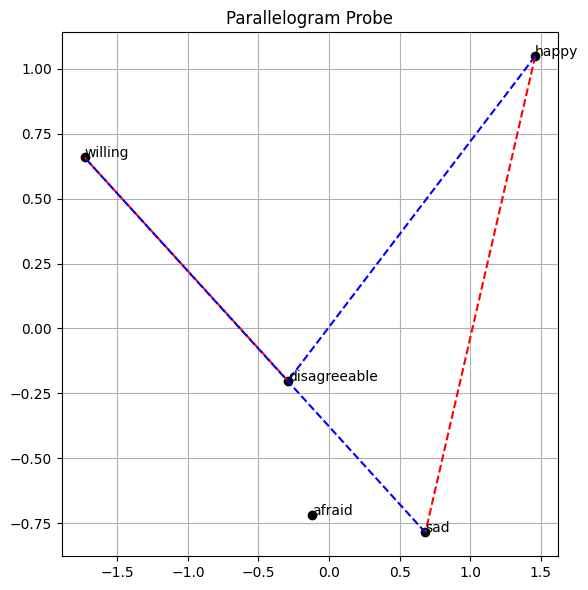


🔍 Probe: ['king', 'queen', 'man', 'woman'] vs apple


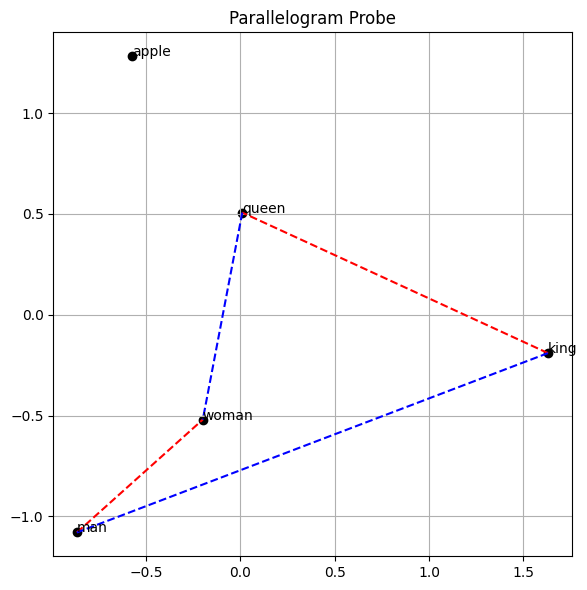


🔍 Probe: ['king', 'knight', 'man', 'maiden'] vs book


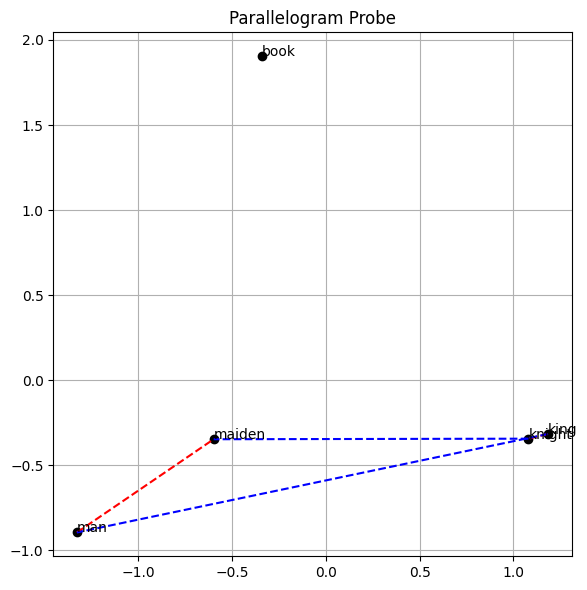


🔍 Probe: ['to', 'from', 'in', 'out'] vs the


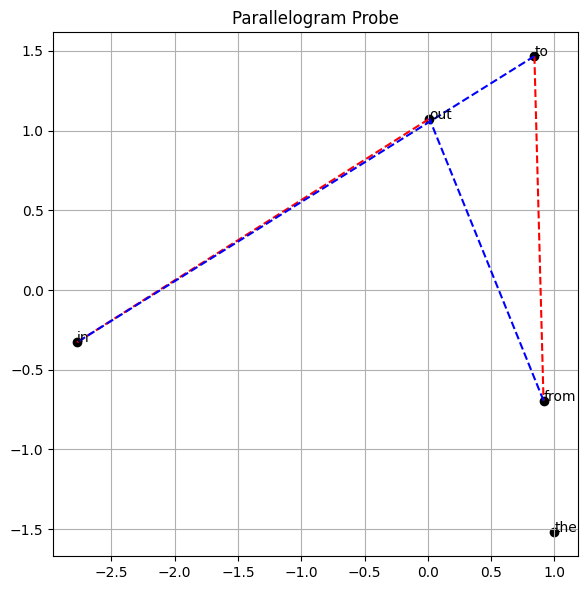

In [ ]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Load vocab ===
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)

stoi = meta["stoi"]
itos = meta["itos"]
device = next(model.parameters()).device
wte = model.transformer.wte

# === Char embedding extractor ===
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if not ids:
        return None
    with torch.no_grad():
        emb = model.transformer.wte(torch.tensor(ids, dtype=torch.long, device=device)).unsqueeze(0)
        #emb = torch.cat(model.transformer.wte(torch.tensor(ids, dtype=torch.long, device=device)).unsqueeze(0), dim=-1)
        return emb.mean(dim=1).squeeze(0).cpu().numpy()

# === Plot one parallelogram ===
def plot_parallelogram(words, outlier=None):
    vecs = [get_char_embedding(w) for w in words]
    labels = words.copy()
    if outlier:
        vecs.append(get_char_embedding(outlier))
        labels.append(outlier)

    # drop None values
    vecs = [v for v in vecs if v is not None]
    if len(vecs) < 4:
        print(f"⚠️ Not enough valid embeddings for: {labels}")
        return

    vecs = np.stack(vecs)
    proj = PCA(n_components=2).fit_transform(vecs)

    plt.figure(figsize=(6, 6))
    plt.scatter(proj[:, 0], proj[:, 1], color='black')
    for i, label in enumerate(labels):
        plt.text(proj[i, 0], proj[i, 1], label, fontsize=10)

    if len(proj) >= 4:
        A, B, C, D = proj[:4]
        plt.plot([A[0], B[0]], [A[1], B[1]], 'r--')
        plt.plot([C[0], D[0]], [C[1], D[1]], 'r--')
        plt.plot([A[0], C[0]], [A[1], C[1]], 'b--')
        plt.plot([B[0], D[0]], [B[1], D[1]], 'b--')

    plt.title("Parallelogram Probe")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Define test sets ===
test_sets = [
    (["why", "what", "where", "when"], "who"),               # verb→third person
    (["prepare", "begin", "cease", "end"], "remain"),               # singular→plural
    (["happy", "sad", "disagreeable", "willing"], "afraid"),       # negation prefix
    (["king", "queen", "man", "woman"], "apple"),            # gender pairs
    (["king", "knight", "man", "maiden"], "book"),
    (["to", "from", "in", "out"], "the"),                    # function-word symmetry
]

# === Run all probes ===
for words, outlier in test_sets:
    print(f"\n🔍 Probe: {words} vs {outlier}")
    plot_parallelogram(words, outlier)


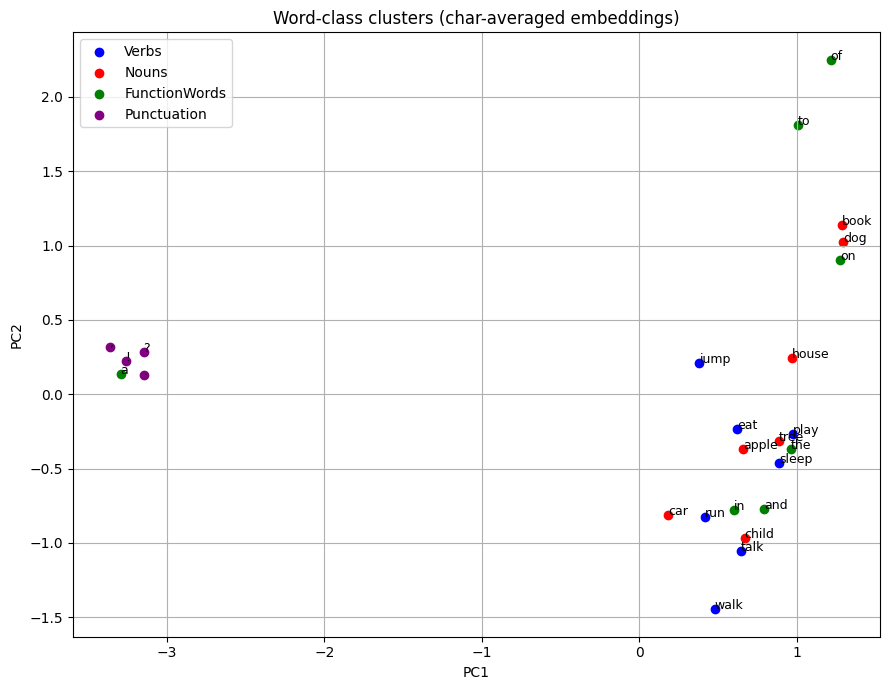

In [ ]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.transformer.wte
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = model.transformer.wte(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [ ]:
file_path = 'simple_model.pth'

# 3. Save the model's state_dict
torch.save(model.state_dict(), file_path)